# Determinación experimental del foco de una lente


1. Cargar lente de Fresnel
1. Busqueda de z=0
1. Busqueda de focal
1. Toma de imágenes entorno a la focal
1. Cargar imagenes en Scalar_field_XYZ
1. Análisis de las imagénes


## Inicio

## Cargar Módulos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_fields_XYZ import Scalar_field_XYZ
from py_lab.camera import Camera
from py_lab.motor_linear import Motor
from py_lab.slm import SLM
from py_lab.utils import List_COM_Ports
from numpy import pi

import time
import cv2
import matplotlib

# Camara
ms=1.
seconds=1000*ms

# Motores
s = 1

%matplotlib qt
%matplotlib inline

number of processors: 4
total memory        : 6.0 Gb
available memory    : 64 %
max frequency       : 2794 GHz


In [3]:
from matplotlib import rcParams
rcParams['figure.dpi']=300
rcParams['image.cmap']='hot'

## Primer paso: Controlar la cámara, el motor y el modulador. 

Encendemos la cámara, el motor y el modulador y los activamos para que sea Python el que los controle. 
Comenzamos con la cámara, y tomamos una imagen para comprobar que funciona. 

In [4]:
# Cámara
cam = Camera(name="ImagingSource") 
devices = cam.List_Devices(verbose=True)
cam.Open()
cam.Set_Property("Resolution", "Y800 (1024x768)")
# Framerate
cam.Set_Property("FrameRate", 5)
# Otros parametros
cam.Set_Property("Gain", 0, is_switcher=True)
cam.Set_Property("Gain", 2)
#Aquí podemos variar el tiempo de exposición de la cámara. 
value=int(np.log2(1/2000.))
print(value)
cam.Set_Property("Exposure", value)
cam.Start_Live() 


0 : b'DMx 72BUC02 14210296'



-10



In [5]:
cam.Set_Property("Exposure", -13)


In [6]:
# Comprobamos que se obtiene una imagen. 
image = cam.Get_Image(draw=True)



Ahora toca manejar el motor: 

In [7]:
motor = Motor(name='SMC100')
motor.Open(port='COM3')
motor.Test_Connection()
#El Home es una función inicial para despazar el motor a un punto concreto fijo, el 0 de su sistema. 
motor.Home()

Connecting to SMC100 on COM3
Found stage ILS250PP_PN:B0921669954252_UD:091029
Stage SMC100 ready


Por último. queda el uso del modulador: 

In [8]:
slm = SLM(name="HoloEye2500", M=0.7950)

# Segundo paso: Lente de fresnel

In [9]:
length = 2*mm
focal=125*mm
lens_radius=2*mm
df = 63*mm


In [10]:
background = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
background.one_level(0)

In [11]:
mask = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
mask.fresnel_lens(r0=(0 * um, 0 * um),radius=lens_radius,focal=focal,angle=0,kind='amplitude',phase=0,mask=True)
mask.draw(kind='intensity')

slm.Send_Image(mask, norm=1, kind='intensity')

## Busqueda de la posición del foco

In [12]:
num_data_x, num_data_y=image.shape
numdata_z = 64
pixel_size=2.2*um

In [13]:
#Para mover el motor, fijamos una velocidad y una posición absoluta, entre -125 Y 125 ("pos"). 
z_motor = 110.1989
z_foco=z_motor - focal/mm
motor.Set_Velocity(vel=20, units='mm/s')
motor.Move_Absolute(pos=z_foco,units='mm', verbose=True, move_time=None)

-14.80108

In [46]:
z_delay=+10*mm
x_delay=200*um

In [15]:
u_foco = cam.Get_Image(diffractio=True)
u_foco.draw()
u_foco.save_mask('data/foco.bmp');

In [54]:
z_foco=z_motor - focal/mm

x0 = np.linspace(-pixel_size*num_data_x / 2, pixel_size*num_data_x / 2, num_data_x)
y0 = np.linspace(-pixel_size*num_data_x / 2, pixel_size*num_data_x / 2, num_data_y)
z_motor = np.linspace(z_foco-df/2/mm, z_foco+df/2/mm, numdata_z)

z_opt =  np.linspace(focal-df/2, focal+df/2, numdata_z) 
wavelength = 0.6328 * um

In [17]:
z_motor=z_motor-z_delay/mm

In [55]:
x0_opt=x0+x_delay

In [56]:
u_xyz.x=x0_opt

In [19]:
# estructura para guardar
u_xyz= Scalar_field_XYZ(x=x0, y=y0, z=z_opt, wavelength=wavelength)

# Tercer paso: movimiento del motor


In [20]:
cam.Set_Property("Exposure", -13)
cam.Set_Property("Gain", 3)


In [21]:
image = cam.Get_Image(draw=False, )


In [22]:
slm.Send_Image(background, norm=1, kind='intensity')
time.sleep(0.3)
im_background=cam.Get_Image(draw=False, is_background=True )

In [23]:
print("num_steps = {}".format(len(z_motor)))
print("final     = {}".format(z_motor[-1]))

num_steps = 64
final     = 6.698899999999995


In [24]:
for i,z in enumerate(z_motor):
    motor.Move_Absolute(pos=z_motor[i],units='mm', verbose=True, move_time=None);
    slm.Send_Image(background, norm=1, kind='intensity')
    time.sleep(0.3)
    im_background=cam.Get_Image(draw=False, is_background=True )
    time.sleep(0.3)
    slm.Send_Image(mask, norm=1, kind='intensity')

    image = cam.Get_Image(draw=False, rest_background=True )
    u_xyz.u[:,:,i]=np.sqrt(image)
    # filename="{}_{:0>3d}.npz".format('focoxyz',i)
    # np.savez(filename, image=image)
    # print(filename, end='\r')

In [25]:
# u_xyz.draw_XYZ()

In [26]:
u_xz=u_xyz.to_Scalar_field_XZ(y0=0)
x_focus,z_focus=u_xz.search_focus()

x = -166.317 um, z = 127500.000 um


In [27]:
u_xyz.beam_widths(  kind='FWHM2D',
                    has_draw=[True, False],
                    percentaje=0.4,
                    verbose=False)
plt.ylim(ymin=0)

h:\codigo\diffractio\diffractio\utils_optics.py:333: RuntimeWarning: divide by zero encountered in double_scalars
  x_left = i_left * delta_x - distance_left / slope_left


(0.0, 544.0521952843641)

h:\codigo\diffractio\diffractio\utils_optics.py:333: RuntimeWarning: divide by zero encountered in double_scalars
  x_left = i_left * delta_x - distance_left / slope_left


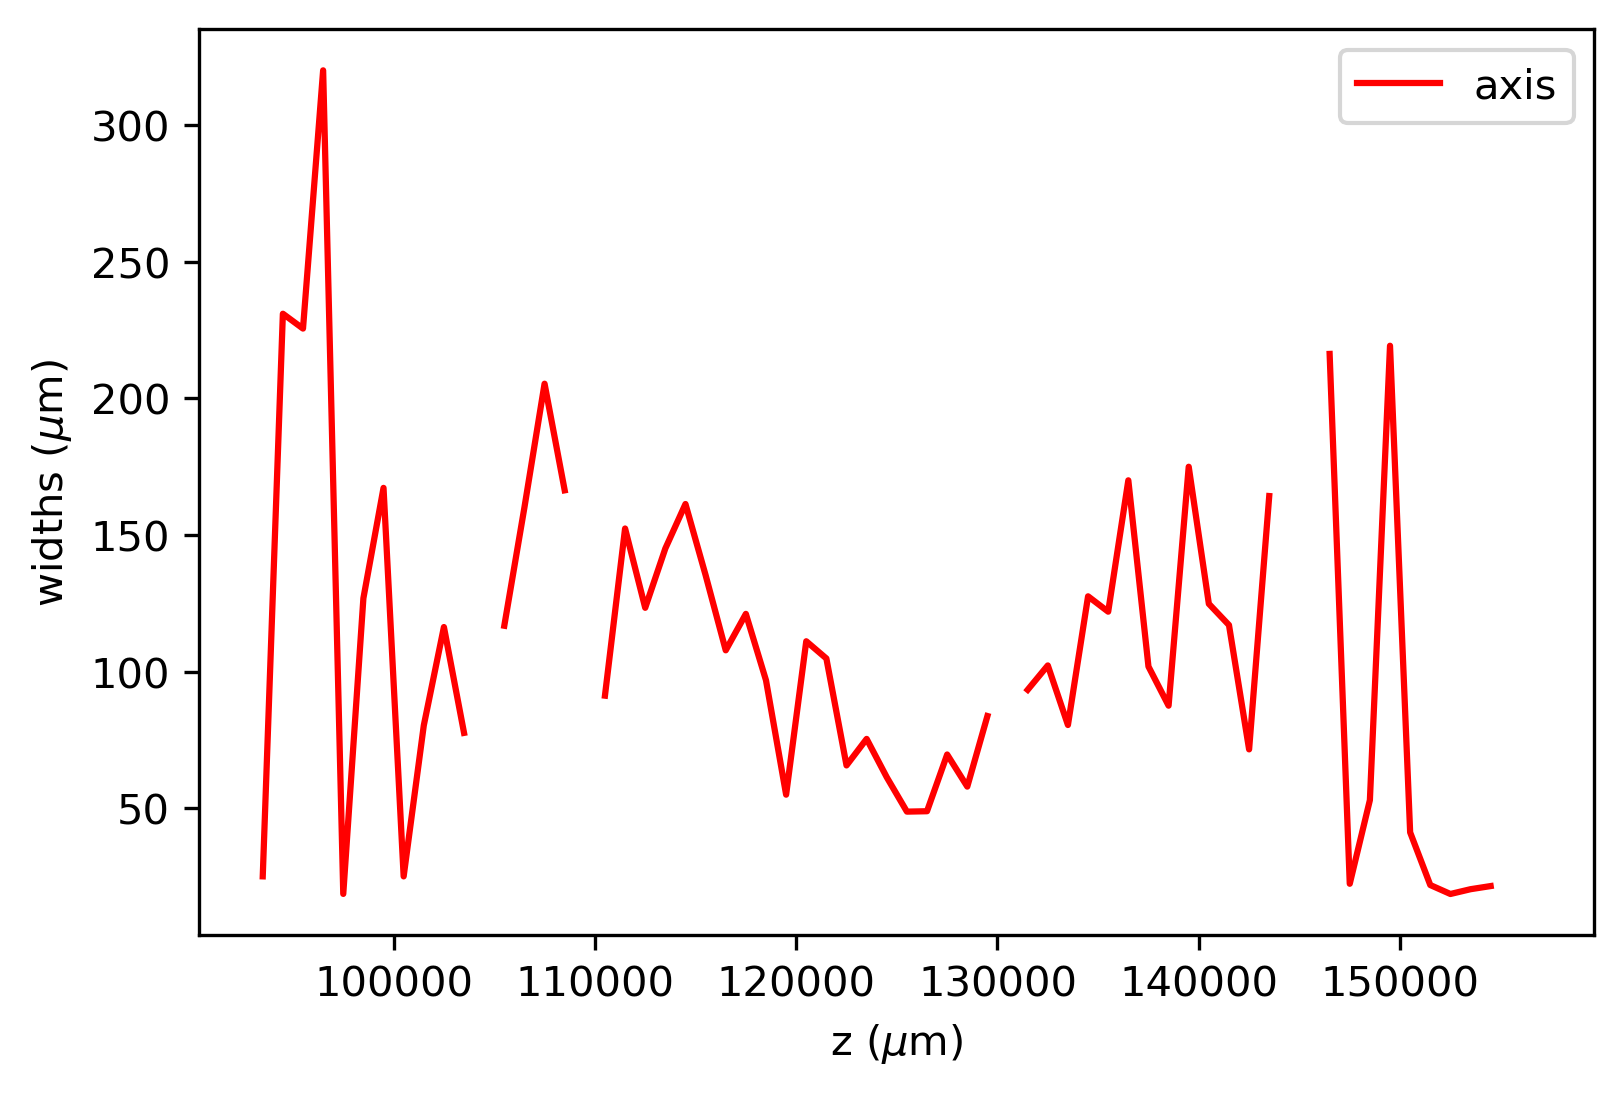

In [28]:
wx,wy, _= u_xyz.beam_widths(kind='FWHM2D', has_draw=[True, False],  percentaje=0.9,  verbose=False)

1337.0931694746364 1483.499603011651


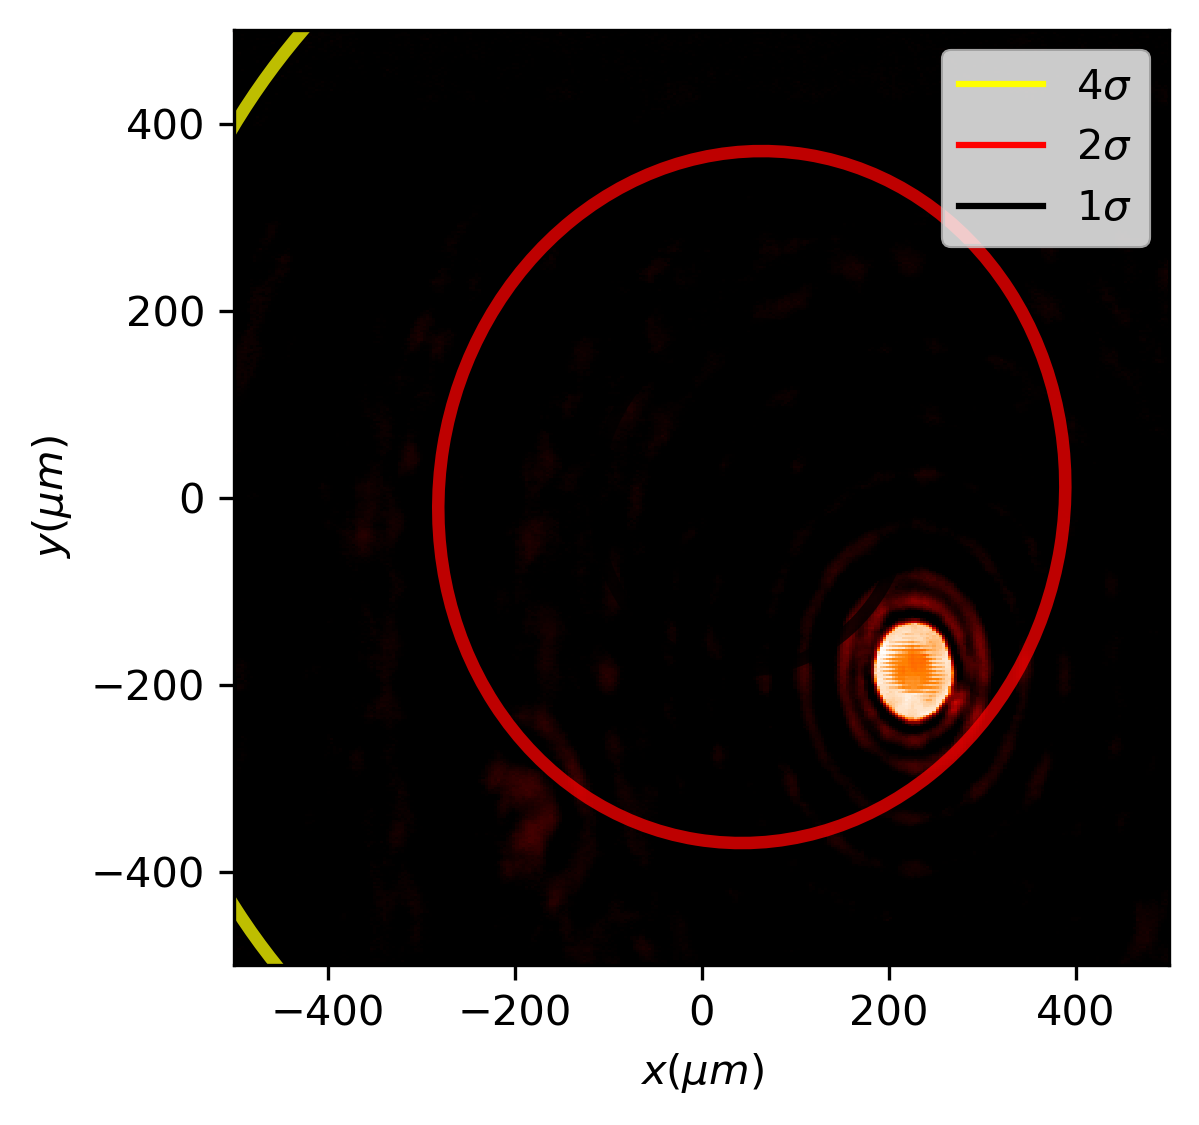

In [57]:
u_xy=u_xyz.to_Scalar_field_XY(z0=z_focus)
dx,dy,_,_=u_xy.beam_width_4s(has_draw=True); plt.xlim(-500,500); plt.ylim(-500,500)
print(dx,dy)

In [68]:
u_xyz.draw_XZ(y0=25, logarithm=False)
plt.title('')
plt.tight_layout()
plt.savefig('lens_standard.pdf')
plt.ylim(-600,200)

(-600.0, 200.0)